# Caledon Woods & I
    
Let's see how successful I am with Caledon Woods. I will attempt to draw insights on the following questions:

1. Can I measure my performace over time?
2. What holes cause harship? And how consistent are these hardships?
3. What types of holes cause the harship?
4. How does putting, fairways, and greens impact your score?

In [2]:
%load_ext autoreload
%autoreload 2
from sys import path
path.append('../../../../')                                         # Import the entire project.
from My_Golf_Journey.src.bin.stat_apis.get_golf_stats import Stats
s = Stats()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing

## 1 - Performance Over Time

* How has my performance varied over time?


## 2 - Hole-By-Hole Breakdown

* How do I perform on certain holes?
* How has my scoring average on certain holes improved?

Text(0.5, 1.0, 'Performance Metrics (Higher = Bad)')

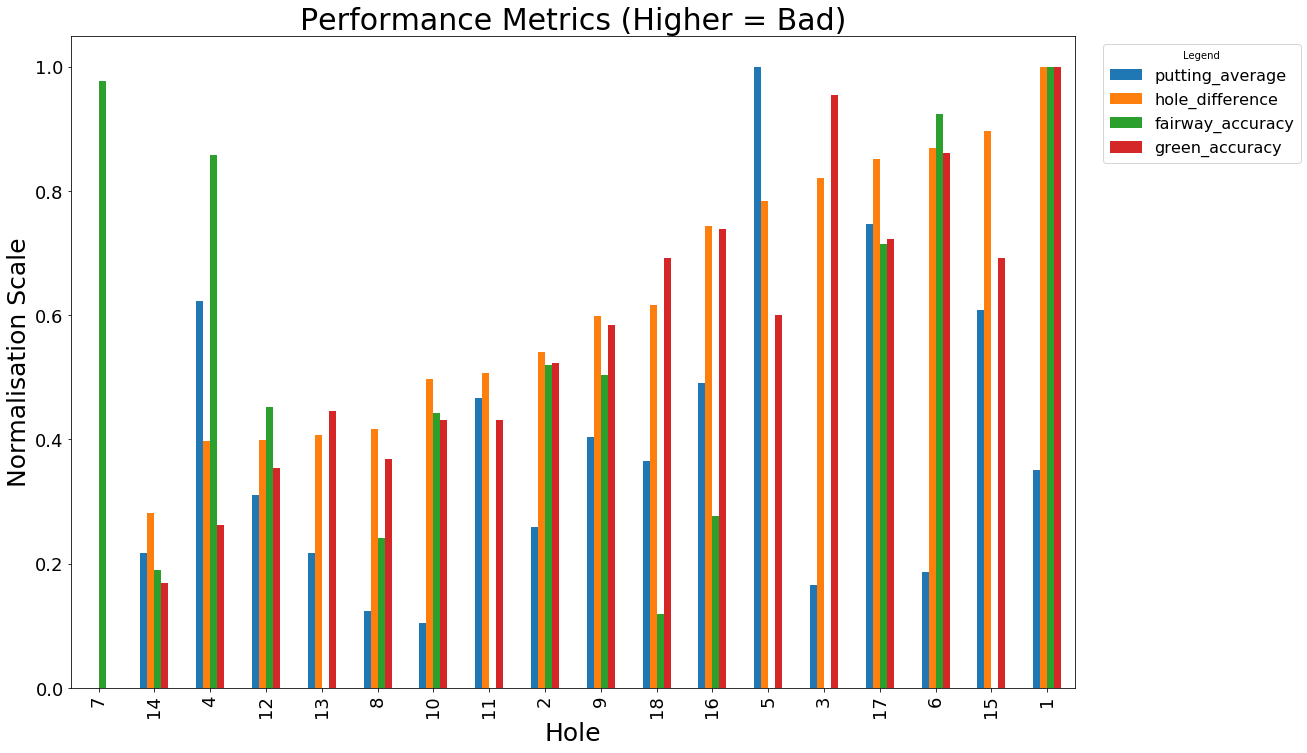

In [97]:
# Calculate the number of putts per hole with normalisation.
df_putt = s.get_putting_avg_by_hole(17772)
df_score = s.get_scoring_avg_by_hole(17772)
fairway_accuracy = s.get_fairway_accuracy(17772)
green_accuracy = s.get_green_accuracy(17772)
df_score['hole_difference'] = df_score['scoring_average'] - df_score['Par']
df = df_putt.join(df_score)                                                      # Dataframe columns: putting_average  scoring_average  Par  hole_difference
df['fairway_accuracy'] = fairway_accuracy['Accuracy'].apply(lambda x: 1 - x)     # Invert the percentages for graphics readability.
df['green_accuracy'] = green_accuracy['hit_percentage'].apply(lambda x: 1 - x)
min_max_scaler = preprocessing.MinMaxScaler()                                    # Perform the normalisation.
df = pd.DataFrame(min_max_scaler.fit_transform(df.values), columns=['putting_average', 'scoring_average', 'Par', 'hole_difference', 'fairway_accuracy', 'green_accuracy'])
df.index = range(1,len(df)+1)
df = df.drop(columns=['Par', 'scoring_average']).sort_values(by=['hole_difference'])
df.plot(kind='bar', figsize=(18, 12))
plt.legend(title='Legend', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=16)
plt.ylabel('Normalisation Scale', fontsize=25)
plt.xlabel('Hole', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Performance Metrics (Higher = Bad)', fontsize=30)

In [10]:
caledon_rounds = list(s.collection.aggregate([
    {"$match": {"courseSnapshots.courseGlobalId": 17772,
                "scorecardDetails.scorecard.holesCompleted": 18.0
    }},
    {"$unwind": "$scorecardDetails"},
    {"$sort": {"scorecardDetails.scorecard.startTime" : 1}},
    {"$project": {"_id": 0, "scorecardDetails.scorecard.startTime": 1}}
]))
print(len(caledon_rounds))
dates = [caledon_rounds[i]['scorecardDetails']['scorecard']['startTime'] for i in range(0, len(caledon_rounds), 5)]
print(len(dates))

129
26


In [11]:
# Get all the score data overtime. The final format is {'Date': '2020-10-18', 'putting_average': 34, 'scoring_average': 81}.
caledon_rounds = list(s.collection.aggregate([
    {"$match": {"courseSnapshots.courseGlobalId": 17772,
                 "scorecardDetails.scorecard.holesCompleted": 18.0
    }},
    {"$unwind": "$scorecardDetails"},
    {"$sort": {"scorecardDetails.scorecard.startTime" : -1}},

    {"$project": {
        "_id": 0,
        "Date": "$scorecardDetails.scorecard.startTime", 
        "putting_average": "$scorecardDetails.scorecardStats.round.putts",
        "scoring_average": "$scorecardDetails.scorecard.strokes"
        }}
]))
for count, round in enumerate(caledon_rounds):
    round['Date'] = round['Date'][0:10]

In [185]:
df = pd.DataFrame(caledon_rounds)
df['PA'] = df.rolling(window=4)['putting_average'].mean()
df['SA'] = df.rolling(window=4)['scoring_average'].mean()
df = df[df['SA'].notna()]
df = df.sort_values(by=['Date'], ascending=True)
#df = df.iloc[::3, :]

Text(0.5, 0.98, 'Moving Score Average: N=4')

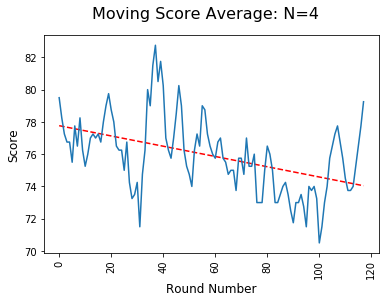

In [192]:
plt.figure(1)
plt.xticks(rotation=90)
linear_scale = [i for i in range(0, len(df))]
x_scale = linear_scale
z = np.polyfit(x_scale, df['SA'], 1)
p = np.poly1d(z)
plt.plot(x_scale, p(x_scale),"r--")
plt.plot(x_scale, df['SA'])
plt.xlabel('Round Number', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.suptitle('Moving Score Average: N=4', fontsize=16)
# plt.plot(x_scale, df['PA'])

Text(0.5, 0.98, 'Moving Putting Average: N=4')

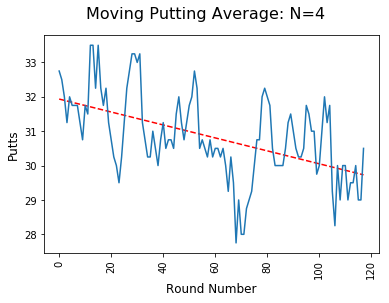

In [193]:
plt.figure(1)
plt.xticks(rotation=90)
linear_scale = [i for i in range(0, len(df))]
x_scale = linear_scale
z = np.polyfit(x_scale, df['PA'], 1)
p = np.poly1d(z)
plt.plot(x_scale, p(x_scale),"r--")
plt.plot(x_scale, df['PA'])
plt.xlabel('Round Number', fontsize=12)
plt.ylabel('Putts', fontsize=12)
plt.suptitle('Moving Putting Average: N=4', fontsize=16)